In [1]:
%cd ../..
%pwd
from __future__ import annotations
import os, json, glob, re, math, random, itertools
from pathlib import Path
from collections import Counter, defaultdict

import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


In [2]:
ANSWERS_DIR      = Path("e_confirm_xy_yx/outputs/matched_vals_gt")
ACTIVATIONS_DIR  = Path("h_hidden_space/outputs/f1_hint_xyyx/xyyx_deterministic")
PROBE_SAVE_DIR   = Path("linear_probes"); PROBE_SAVE_DIR.mkdir(exist_ok=True)
RANDOM_SEED      = 0
torch.manual_seed(RANDOM_SEED); random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)


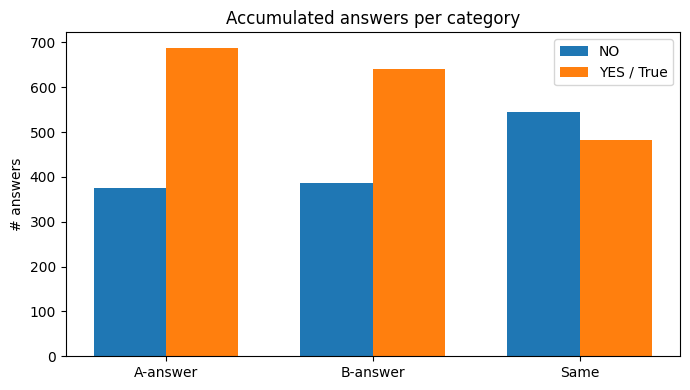

In [3]:
def iter_answer_files(answer_dir: Path):
    for fp in answer_dir.glob("*.json"):
        with open(fp) as f:
            yield json.load(f), fp.name

a_counter, b_counter, same_counter = Counter(), Counter(), Counter()

for data, name in iter_answer_files(ANSWERS_DIR):
    questions = data["questions"] if isinstance(data, dict) else data

    for q in questions:
        a_counter[q["a_answers"][0]]   += 1
        b_counter[q["b_answers"][0]]   += 1
        same_counter[q["same"][0]]     += 1

for k in ("YES", "NO"):        # for a_ / b_
    a_counter.setdefault(k, 0)
    b_counter.setdefault(k, 0)
for k in (True, False):
    same_counter.setdefault(k, 0)

fig, ax = plt.subplots(figsize=(7, 4))
groups   = ["A-answer", "B-answer", "Same"]
yes_vals = [a_counter["YES"], b_counter["YES"], same_counter[True]]
no_vals  = [a_counter["NO"],  b_counter["NO"],  same_counter[False]]

x = np.arange(len(groups))
width = 0.35
ax.bar(x - width/2, no_vals, width, label="NO")
ax.bar(x + width/2, yes_vals, width, label="YES / True")
ax.set_xticks(x); ax.set_xticklabels(groups)
ax.set_ylabel("# answers")
ax.set_title("Accumulated answers per category")
ax.legend(); plt.tight_layout()


In [4]:
TOKENIZER_NAME = "huggyllama/llama-7b"
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
tok.pad_token = tok.eos_token

ANSWER_TOKEN_IDS = {t: tok.encode(t, add_special_tokens=False)[0] for t in ("YES", "NO")}
print(ANSWER_TOKEN_IDS)  # {'YES': 13023, 'NO': 19353}


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


{'YES': 22483, 'NO': 11698}


In [5]:
import re

def parse_expected_from_fname(fname: str) -> str:
    m = re.search(r"_(?:gt|lt)_(YES|NO)_", fname)
    if not m:
        raise ValueError(f"Cannot parse YES/NO from {fname}")
    return m.group(1)


In [6]:
import time, itertools, math, re, torch
from pathlib import Path
from collections import defaultdict
from transformers import AutoModelForCausalLM

MODEL_PATH  = "huggyllama/llama-7b"
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_FILES  = 5
LOG_EVERY = 1

print("Loading model to read out lm_head…")
t0 = time.time()
_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH, torch_dtype=torch.float32, low_cpu_mem_usage=True
).to(DEVICE).eval()
print(f"  ↳ done in {time.time()-t0:.1f}s")

W = _base_model.lm_head.weight.detach().cpu()          # (vocab, hdim)
b = (_base_model.lm_head.bias.detach().cpu()
     if _base_model.lm_head.bias is not None else None)

yes_w = W[ANSWER_TOKEN_IDS["YES"]]                     # (hdim,)
no_w  = W[ANSWER_TOKEN_IDS["NO"]]
yes_b = b[ANSWER_TOKEN_IDS["YES"]] if b is not None else 0.0
no_b  = b[ANSWER_TOKEN_IDS["NO"]]  if b is not None else 0.0

def yes_no_from_hidden(h: torch.Tensor) -> str:
    """Return 'YES' or 'NO' by comparing lm-head logits."""
    yes_score = float(torch.dot(h, yes_w) + yes_b)
    no_score  = float(torch.dot(h,  no_w) + no_b)
    return "YES" if yes_score > no_score else "NO"

def hidden_files() -> list[Path]:
    """Return sorted list of *_hidden.pt paths (optionally truncated)."""
    paths = sorted(ACTIVATIONS_DIR.rglob("*_hidden.pt"))
    return paths if MAX_FILES is None else paths[:MAX_FILES]

layer_buckets: dict[int, list[tuple[torch.Tensor, int]]] = defaultdict(list)

all_paths = hidden_files()
n_files   = len(all_paths)
print(f"Processing {n_files} hidden-state files…")

use_tqdm = False
try:
    from tqdm.auto import tqdm
    use_tqdm = True
except Exception:
    pass

iterator = tqdm(all_paths, desc="hidden.pt") if use_tqdm else all_paths
start = time.time()

for idx, hid_path in enumerate(iterator, 1):
    expected = parse_expected_from_fname(hid_path.name)    # YES / NO
    batch_hidden: list[torch.Tensor] = torch.load(hid_path)    # list[n_layers] of (B,h)

    last_layer = batch_hidden[-1]                     # (B, h)
    preds = [yes_no_from_hidden(h.float()) for h in last_layer]

    for L, layer_tensor in enumerate(batch_hidden):            # layer_tensor : (B, h)
        for h_vec, pred in zip(layer_tensor, preds):
            label = 1 if pred == expected else 0         # 1 = correct, 0 = wrong
            layer_buckets[L].append((h_vec.float(), label))

    if not use_tqdm and idx % LOG_EVERY == 0:
        print(f"  processed {idx}/{n_files} files …")

elapsed = time.time() - start
print(f"Finished collecting activations in {elapsed/60:.1f} minutes")

for L in sorted(layer_buckets)[:5]:
    print(f"  layer {L:2d}  →  {len(layer_buckets[L]):,} samples")

Loading model to read out lm_head…


Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


  ↳ done in 13.6s
Processing 5 hidden-state files…


hidden.pt:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_37410/1308734137.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_hidden: list[torch.Tensor] = torch

Finished collecting activations in 0.0 minutes
  layer  0  →  132 samples
  layer  1  →  132 samples
  layer  2  →  132 samples
  layer  3  →  132 samples
  layer  4  →  132 samples


In [7]:
PRINT_FIRST_N     = 10    # show the first N samples
LOW_CONF_THRESH   = 0.90  # also print any sample whose max-prob < this
SHOW_LAYER        = -1    # which layer’s vector to inspect (−1 = last)

sample_counter = 0

def yes_no_logits(h: torch.Tensor) -> tuple[float, float]:
    """Return raw logits (YES, NO)."""
    return (float(torch.dot(h, yes_w) + yes_b),
            float(torch.dot(h,  no_w) + no_b))

def softmax2(a: float, b: float) -> tuple[float, float]:
    """Stable soft-max for two numbers."""
    mx = max(a, b)
    ea, eb = math.exp(a - mx), math.exp(b - mx)
    denom   = ea + eb
    return ea / denom, eb / denom            # (p_yes, p_no)

for idx, hid_path in enumerate(all_paths, 1):
    expected = parse_expected_from_fname(hid_path.name)         # "YES"/"NO"
    batch_hidden: list[torch.Tensor] = torch.load(hid_path)
    vecs     = batch_hidden[SHOW_LAYER]                         # (B, H)

    for j, h_vec in enumerate(vecs):                            # loop over batch
        s_yes, s_no = yes_no_logits(h_vec.float())
        p_yes, p_no = softmax2(s_yes, s_no)
        conf, emitted = (p_yes, "YES") if p_yes > p_no else (p_no, "NO")

        # decide whether to print this sample
        want_print = (sample_counter < PRINT_FIRST_N) or (conf < LOW_CONF_THRESH)
        if want_print:
            print(f"[{sample_counter:05d}] file={hid_path.name}  "
                  f"batch_idx={j:<2}  expected={expected:<3}  emitted={emitted:<3}  "
                  f"pYES={p_yes:.3f}  pNO={p_no:.3f}")
        sample_counter += 1

[00000] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=0   expected=NO   emitted=YES  pYES=0.626  pNO=0.374
[00001] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=1   expected=NO   emitted=YES  pYES=0.639  pNO=0.361
[00002] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=2   expected=NO   emitted=YES  pYES=0.706  pNO=0.294
[00003] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=3   expected=NO   emitted=YES  pYES=0.711  pNO=0.289
[00004] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=4   expected=NO   emitted=YES  pYES=0.778  pNO=0.222
[00005] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=5   expected=NO   emitted=YES  pYES=0.606  pNO=0.394
[00006] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=6   expected=NO   emitted=YES  pYES=0.617  pNO=0.383
[00007] file=wm-book-length_gt_NO_1_6fda02e3_batch0_hidden.pt  batch_idx=7   expected=NO   emitted=YES  pYES=0.641  pN

/tmp/ipykernel_37410/3179735467.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_hidden: list[torch.Tensor] = torch.load(hid_path)


In [8]:
import time, random, numpy as np, torch
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

MAX_SAMPLES_PER_LAYER = 1_000          # ← subsample cap (None = all)
PRINT_EVERY_LAYERS    = 5              # ← full line every k layers
sk_verbose            = 0              # 0 = silent, 1 = spammy

results   = {}
layer_ids = sorted(layer_buckets)

print(f"\n=== Training probes for {len(layer_ids)} layers "
      f"(≤ {MAX_SAMPLES_PER_LAYER or 'all'} samples/layer) ===")

bar = tqdm(layer_ids, desc="Layer", leave=True)
t_global = time.time()

for i, L in enumerate(bar, 1):
    pairs = layer_buckets[L]

    # ── optional subsample ────────────────────────────────────────
    if MAX_SAMPLES_PER_LAYER is not None and len(pairs) > MAX_SAMPLES_PER_LAYER:
        pairs = random.sample(pairs, MAX_SAMPLES_PER_LAYER)

    X = torch.stack([p[0] for p in pairs]).numpy()
    y = np.array([p[1] for p in pairs])

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )

    t0 = time.time()
    probe = LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=10_000,
        n_jobs=-1,
        verbose=sk_verbose,      # <-- silence scikit-learn
    ).fit(X_tr, y_tr)
    f1 = f1_score(y_val, probe.predict(X_val))
    dt = time.time() - t0

    results[L] = (f1, probe)

    # update bar text instead of printing a new line
    bar.set_postfix(layer=L, valF1=f"{f1:.3f}", secs=f"{dt:.1f}")

    # optional coarse summary every k layers
    if i % PRINT_EVERY_LAYERS == 0:
        print(f"  ↳ layer {L:2d} finished  |  val-F1 {f1:.3f}  |  {dt:.1f}s")

bar.close()
print(f"Total probe training time: {(time.time()-t_global)/60:.1f} min")

# ── pick best layer & save probe ─────────────────────────────────
best_layer, (best_f1, best_probe) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\nBest layer = {best_layer}   (F1 = {best_f1:.3f})")

outfile = PROBE_SAVE_DIR / f"linear_probe_layer{best_layer}.joblib"
joblib.dump(best_probe, outfile)
print(f"Probe saved → {outfile}")


=== Training probes for 33 layers (≤ 1000 samples/layer) ===


Layer:  15%|█▌        | 5/33 [00:08<00:59,  2.14s/it, layer=4, secs=3.2, valF1=0.000]

  ↳ layer  4 finished  |  val-F1 0.000  |  3.2s


Layer:  30%|███       | 10/33 [00:31<01:27,  3.79s/it, layer=9, secs=0.9, valF1=0.000]

  ↳ layer  9 finished  |  val-F1 0.000  |  0.9s


Layer:  45%|████▌     | 15/33 [00:43<00:41,  2.31s/it, layer=14, secs=1.6, valF1=0.000]

  ↳ layer 14 finished  |  val-F1 0.000  |  1.6s


Layer:  61%|██████    | 20/33 [00:58<00:42,  3.28s/it, layer=19, secs=4.4, valF1=0.000]

  ↳ layer 19 finished  |  val-F1 0.000  |  4.4s


Layer:  76%|███████▌  | 25/33 [01:28<00:47,  5.94s/it, layer=24, secs=7.3, valF1=0.000]

  ↳ layer 24 finished  |  val-F1 0.000  |  7.3s


Layer:  91%|█████████ | 30/33 [02:15<00:27,  9.24s/it, layer=29, secs=10.7, valF1=0.000]

  ↳ layer 29 finished  |  val-F1 0.000  |  10.7s


Layer: 100%|██████████| 33/33 [02:55<00:00,  5.33s/it, layer=32, secs=16.4, valF1=0.167]

Total probe training time: 2.9 min

Best layer = 30   (F1 = 0.167)
Probe saved → linear_probes/linear_probe_layer30.joblib


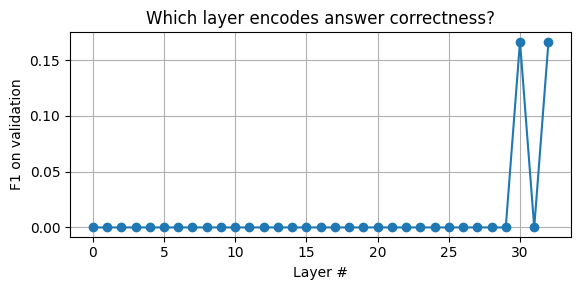

In [9]:
plt.figure(figsize=(6,3))
layers   = sorted(results)
f1s      = [results[L][0] for L in layers]
plt.plot(layers, f1s, marker="o")
plt.xlabel("Layer #"); plt.ylabel("F1 on validation"); plt.grid(True)
plt.title("Which layer encodes answer correctness?")
plt.tight_layout()